In [1]:
import cooler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bioframe
import cooltools
from bioframe.tools import bedtools
from bioframe.io.process import tsv
from cooltools import eigdecomp
from hmmlearn import hmm
import pybedtools
import math
from multiprocessing import Pool
import pickle

In [2]:
def bedtools_intersect(left, right, rsuffix='_', **kwargs):
   
    with tsv(left) as a, tsv(right) as b:
        out = bedtools.intersect(a=a.name, b=b.name,wa=False, wb=False, loj=True, **kwargs)
    return out


In [3]:
def drop_between(df, identifier, start, end, signal):
    same_id = df[ (df[identifier] != '.') & df.duplicated([identifier], keep=False)]
    if len(same_id) == 0:
        return df
    
    l1 = same_id[(same_id[start] > same_id['start']) & ((same_id['end'] - same_id[start]) <=  (same_id[end] - same_id['end']))]
    l2 = same_id[(same_id[start] < same_id['start']) & ((same_id['start'] - same_id[start]) >  (same_id[end] - same_id['start']))]
    test = df.copy()
    test.loc[l1.index, signal] = 0
    test.loc[l2.index, signal] = 0
    return test

In [4]:
def add_peaks(df, signal):
    same_bin = df[ df.duplicated(['start', 'chrom'] , keep=False)] #get peaks in the same bin
    sum_signals = same_bin.groupby(['chrom', 'start']).agg('sum')[signal].values #sum all the signals in same bin
    uniq_bins = same_bin[same_bin.duplicated([ 'chrom', 'start'] , keep='first') == False].copy() #per bin, get the first peak
    test = df[df.duplicated([ 'chrom', 'start'] , keep='first') == False].copy()
    test.loc[uniq_bins.index, signal] = sum_signals
    return test

In [5]:
def transmat_4():
    n_states = 4
    transmat = np.zeros((n_states, n_states))
    transmat[:] = .3
    for i in range(n_states):
        for j in range(n_states):
            if i==j:
                transmat[i, j] = 0.7
    small = 1e-4
    transmat[0,2] = small
    transmat[1,2:] = small
    transmat[2,0:2] = small
    transmat[3,1] = small
    transmat /=  np.sum(transmat,axis=1)[:,None]
    return transmat

def transmat_5():
    n_states = 5
    transmat = np.zeros((n_states, n_states))
    transmat[:] = .2
    for i in range(n_states):
        for j in range(n_states):
            if i==j:
                transmat[i, j] = 0.8

    small = 1e-4
    transmat[0,3] = small
    transmat[1,2:] = small
    transmat[2,1] = small
    transmat[2,3] = small
    transmat[3,0:3] = small
    transmat[4,1] = small
    transmat /=  np.sum(transmat,axis=1)[:,None]
    return transmat

def transmat_6():
    n_states = 6
    transmat = np.zeros((n_states, n_states))
    transmat[:] = .2
    for i in range(n_states):
        for j in range(n_states):
            if i==j:
                transmat[i, j] = 0.6
    small = 1e-4
    transmat[0,3:5] = small
    transmat[1,2:] = small
    transmat[2,0:2] = small
    transmat[2,3:5] = small
    transmat[3,1:3] = small
    transmat[3,4:] = small
    transmat[4,0:4] = small
    transmat[5,1:3] = small
    transmat /=  np.sum(transmat,axis=1)[:,None]
    return transmat

def percentiles_val(n):
    return np.append([25], np.append(50 if n== 3 else np.linspace(45, 55, n-2), np.array([75])))  

def transition_indices(z):
    return np.where(np.abs(np.gradient(z))> 0, True, False )

def build_model(data ,n_components,  n_iter = 30, transmat = 1.0):
    means = np.percentile(data, percentiles_val(n_components)).reshape(-1,1)
    if not (type(transmat) == type(1.0)): n_iter = 100
    model = hmm.GaussianHMM(n_components,
                        algorithm = 'viterbi',
                        transmat_prior= transmat if(type(transmat) == type(1.0)) else   1+ (10**(n_components-2))*transmat,
                        means_weight = 10 if n_components==2 else 10e4,
                        means_prior = means,

                        covariance_type='diag', 
                        params='smct',
                        init_params='sc', 
                        n_iter= n_iter)

    if not (type(transmat) == type(1.0)):
        model.transmat_ = transmat

    startprob = np.zeros(n_components)
    startprob[:] = 0.1
    startprob[0]=0.4
    startprob[-1] = 0.4
    startprob /=  np.sum(startprob)
    model.startprob_ = startprob

    model.means_ = means
    model.fit(data)
    return model


def train_models(data):
    transmat = {4:transmat_4(), 5:transmat_5(), 6:transmat_6()}
    models = { n:build_model(data, n, transmat = transmat.get(n, 1.0)) for n in range(2,7) }
    predicted = { n:models[n].predict(data) for n in range(2,7)}
    return models, predicted

def transition_indices(z):
    return np.append(np.where(np.abs(np.diff(z))> 0, True, False ), [False])

In [6]:
#This will give the values gotten from a lower resolution analysis to bins of higher resolution
def downsample(coolpath, cool_df, curr_res, new_res):
    c = cooler.Cooler(coolpath+ '::/resolutions/'+str(new_res))
    bins = c.bins()[:]
    rate = int(curr_res/new_res)
    regions = cool_df.chrom.unique()
    eig_list = list()
    for ch in regions:
        loc_eig = cool_df[cool_df.chrom == ch]
        loc = bins[bins.chrom == ch].copy()
        
        a = np.repeat(loc_eig.iloc[:-1, 4:].values, rate, axis = 0)
        b = np.repeat(loc_eig.iloc[-1:, 4:].values, len(loc.iloc[len(loc_eig.iloc[:-1])*rate:]), axis = 0)
        z = np.concatenate((a, b), axis = 0)
        p = pd.concat([loc, 
                        pd.DataFrame(z, 
                                     index=loc.index,
                                    columns = cool_df.columns.tolist()[4:]
                                    )]
                       ,axis =1)
        eig_list.append(p)
    
    
    return pd.concat(eig_list)
    

In [7]:
def beds_csv( assembly, cell_line):
    try:
        beds = pd.read_csv('bedfiles.csv')
    except:
        bed_dir = '/pollard/data/functional_genomics/encode'
        bed_files = glob.glob(bed_dir+ "/**/*bed.gz", recursive = 'True')
        beds = pd.DataFrame([ element.split('/')[5:] + [element]  for element in bed_files],
                        columns=[
                            'cell line','assay', 'file_format', 'output_type',
                            'assembly', 'file_status', 'target', 'biosample_treatment',
                            'lab', 'replicate', 'file_name', 'file_location'])
        beds.to_csv('bedfiles.csv', header=True)
        
    bed_eig = beds[ (beds['cell line']).apply(lambda a: a.replace('-', '')) == cell_line ].copy()
    bed_eig = bed_eig[ bed_eig['assembly'].values == assembly].copy()
    return bed_eig

In [8]:
class Cool_Bed:
    def __init__(self, coolpath, cool_pd, bed_file):
        
        self.bed_file = bed_file
        self.cool_pd = cool_pd
        self.test_pd = cool_pd.copy()
        self.bed = pybedtools.BedTool(self.bed_file)
        self.resolution = cool_pd.iloc[0]['end']-cool_pd.iloc[0]['start']
        
    def analyze(self, new_res = 10000):
        
        
        self.bed_pd = self.bed.to_dataframe()
        if not (new_res == self.resolution):
            self.test_pd = downsample(coolpath, self.cool_pd, self.resolution, new_res)
            self.resolution = new_res
        
        
        test = bedtools_intersect( self.test_pd, self.bed_pd)
        columns = self.test_pd.columns.tolist() + ['chrom_p', 'start_p', 'end_p', 'name_p', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']
        test.columns = columns
        test['signalValue']= test['signalValue'].apply(lambda a: a.replace('.', '0'))
        test['signalValue'] = test['signalValue'].astype(float)
        test = drop_between(test, identifier = 'name_p', start = 'start_p', end = 'end_p', signal = 'signalValue')
        self.inter_pd = add_peaks(test, signal = 'signalValue' )
        
        '''
        try:
            self.hmm_dict = self.bp_hmm(self.HMM_pd)
            self.inter_dict = self.bp_hmm(self.inter_pd)
            #self.plot_analysis(self.inter_dict, self.hmm_dict)
            
        except:
            print('Problem with:', self.bed_file)
        #print(hmm_dict)
        #print(inter_dict)
        '''
        
        

    def chrom_analysis(self, ch):
        chrom_pd = self.cis_eigs[1][self.cis_eigs[1]['chrom'] == ch]
        z = Chrom(chrom_pd, ch)
        z.analyze()
        return z.loc_eig
    
    def load_HMM(self):
        try:
            hmm = pd.read_csv(self.coolpath + '_hmm.csv')
        except:
            with Pool(processes=22) as pool:
                results = pool.map(self.chrom_analysis, self.chroms[0:22])
            hmm = pd.concat(results)
            hmm.to_csv(self.coolpath + '_hmm.csv',index=False, header=True)
        
        return hmm
    
    def intersect(self):
        #inter = self.bed.intersect(pybedtools.BedTool.from_dataframe(self.HMM_pd), wb=True, wa=False)
        #test = inter.to_dataframe(disable_auto_names = True,  header=None)
        
        test = bedtools_intersect(self.bed_pd, self.HMM_pd)
       
        test.drop(range(10, 19), axis=1, inplace=True)
        
        test.iloc[:, 10:] = test.iloc[:, 10:].astype(str, errors = 'ignore')
        test.iloc[:, 10:] = test.iloc[:, 10:].astype(float, errors = 'ignore')
        test.columns = self.colnames
        return test
    
    def bp_hmm(self, df):
        test = df.copy()
        test['bpairs'] = test['end'] - test['start']
        test = test[test['HMM0'] == test['HMM0']]
        bp_dict = dict()
        for hmm in self.colnames[self.colnames.index('HMM0'):][::2]:
            for order in np.sort(test[hmm].unique()):
                if (order == '.'):
                    continue
                
                section = test[test[hmm] == order]
                bp_sum = sum(section['bpairs'].values)
                hmm_dict = bp_dict.get(hmm, dict())
                hmm_dict[str(order)] = bp_sum
                bp_dict[hmm] = hmm_dict
        
        return bp_dict
    
    def plot_analysis(self, dict1, dict2):
        fig = plt.figure(figsize=(15, 3*3))
        fig.suptitle(self.bed_file, fontsize=16)
        gs = gridspec.GridSpec(3*4, 19)
        
        i = 0
        for hmm in dict1.keys():
            ax1 = plt.subplot(gs[int(i/2)*4: int(i/2)*4 + 3, 10*(i%2): 10*(i%2) + 9])
            ax1.set_title(hmm)
            vals = [dict1[hmm][order]/dict2[hmm][order] for order in dict1[hmm].keys()]
            ax1.bar(dict1[hmm].keys(), vals, 1, color='b')
            i+=1
        
        plt.show()
                
        
    

In [9]:
class HMMC:
    def __init__(self, df):
        self.loc_eig = df.copy()
        self.mask = np.isnan(self.loc_eig['E1']) == 0
        self.data = self.loc_eig['E1'][self.mask].values
        
    
    def analyze(self):
        self.model, self.predicted = train_models(self.data.reshape(-1,1))
        self.check_model()
        indexes = self.mask[self.mask == True].index
        conditions, choices = [(self.loc_eig['E1'] >= 0), (self.loc_eig['E1'] <  0)], [1,0]
        self.loc_eig['HMM0']  = np.select(conditions, choices, default= np.nan)
        #self.loc_eig['HMM0_t'] =  pd.Series(data = transition_indices(self.loc_eig[self.mask]['HMM0'].values), index = indexes)

        for n in range(2,7):
            self.loc_eig['HMM' + str(n)] = pd.Series(data = self.predicted[n], index = indexes)
            #self.loc_eig['HMM' + str(n) + '_t'] = pd.Series(data = transition_indices(self.predicted[n]), index = indexes)
        
    def check_model(self):
        shifted = False
        for n in range(2,7):
            l = self.model[n].means_
            flag = 0
            if(not np.array_equal(l, np.sort(l, axis = 0))):
                print('Model ' + str(n) + ' Means shifted')
                print('------------------------------------')
                shifted = True
                
        return shifted

In [10]:
def get_window(pd, chrom, signal, model, coverage):
    curr = pd[pd['chrom'] == chrom]
    z= curr[curr[model]==curr[model]][model].values
    sig = curr[curr[model]==curr[model]][signal].values
    z_t = transition_indices(z)
    
    bound = np.where((z_t == True))[0] ##double check boundaries
    #indexes = bound[np.where(np.diff(bound)>coverage)[0]] ##improve this later
    #print('Bound shape:', bound.shape)
    indexes1 = bound[0::2] #get half of the signals
    indexes2 = bound[1::2] #get the other half
    if z[indexes2[0]] > z[indexes1[0]]:  #Make sure is high to low signal
        test = indexes1
        indexes1 = indexes2
        indexes2 = test
    #print('I1 shape', indexes1.shape)
    #print('I2 shape', indexes2.shape)
    scores1 = np.array([sig[index- coverage: index+coverage+1]  for index in indexes1 if len(sig[index- coverage: index+coverage+1]) > coverage*2])
    scores2 = np.array([np.flip(sig[index- coverage+1: index+coverage+2])  for index in indexes2 if len(sig[index- coverage+1: index+coverage+2]) > coverage*2])

    #print(scores1.shape)
    #print(scores2.shape)
    scores = np.concatenate((scores1, scores2), axis = 0)
    return scores

In [11]:
def eigen_decomposition(coolpath, assembly = 'hg19', bin_res = 100000):
        cool_name = coolpath.split('/')[-1]
        try:
            cis_eigs = (pd.read_csv(cool_name+'_'+str(bin_res) + '_0.csv'), pd.read_csv(cool_name+'_'+str(bin_res) +  '_1.csv'))
            eig_list = [ cis_eigs[1][cis_eigs[1].chrom == chrom] for chrom in cis_eigs[1].chrom.unique()]
            return cis_eigs
        except:
            print('Calculating Eigenvector')
            
            c = cooler.Cooler(coolpath+ '::/resolutions/'+str(bin_res))
            bins = c.bins()[:]
            regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames]
            
            genecov = bioframe.tools.frac_gene_coverage(bins, assembly)
            cis_eigs = eigdecomp.cooler_cis_eig(
                c, 
                genecov, 
                regions,
                n_eigs=3, 
                balance=True,
                phasing_track_col='gene_count',
                ignore_diags = 4
            )
              
            cis_eigs[0].to_csv(cool_name+'_'+str(bin_res) + '_0.csv',index=False, header=True)
            cis_eigs[1].to_csv(cool_name+'_'+str(bin_res) +  '_1.csv',index=False, header=True)
            return cis_eigs  

In [12]:
def run_process(f, collection, epoch):
    
    try:
        
        with Pool(processes=50) as pool:
            r = pool.map(f, collection) 
            print('Succesful Epoch', epoch)
        return r
    except:
        print('Error in collection, epoch:', epoch)
        return [None]

In [13]:
def bed_analysis(x):
    a = Cool_Bed(x[0], x[1], x[2])
    a.analyze()
    return a

In [14]:
def main(coolpath, assembly, cell_line, eig_res = 100000, bin_res = 1000):
    
    bed_eig = beds_csv( assembly, cell_line)
    test_peaks = bed_eig[(bed_eig['replicate'] == 'rep1,2')] #we just want the ones with rep1 and 2
    bed_files = test_peaks.file_location.tolist()
    
    cis_eigs = eigen_decomposition(coolpath, assembly, eig_res)
    H = HMMC(cis_eigs[1])
    H.analyze()
    
    inp = [(coolpath, H.loc_eig, bed) for bed in bed_files]
    
    epochs = math.ceil(len(inp)/50)
    div = np.linspace(0, len(inp), epochs +1, dtype=int)
    
    x =  [run_process(bed_analysis, inp[div[epoch]:div[epoch+1]], epoch) for epoch in range(epochs)]
    return np.array(sum(x, []))

In [15]:
coolpath = '/pollard/data/chromatin_organization/rao2014/distiller-0.3.1_hg19/results/mcools/GM12878_inSitu_MboI.hg19.mapq_30.1000.mcool'
assembly = 'hg19'
cell_line = 'GM12878'
eig_res = 100000
bin_res = 1000

In [16]:
results = main(coolpath, assembly, cell_line, eig_res = 100000, bin_res = 1000)

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 0


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 1


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 2


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 3


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 4


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 5


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 6


/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/s

Succesful Epoch 7


In [17]:
results = np.array(results)

In [18]:
a = results[5]

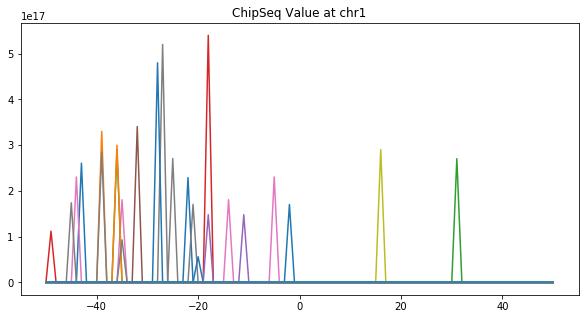

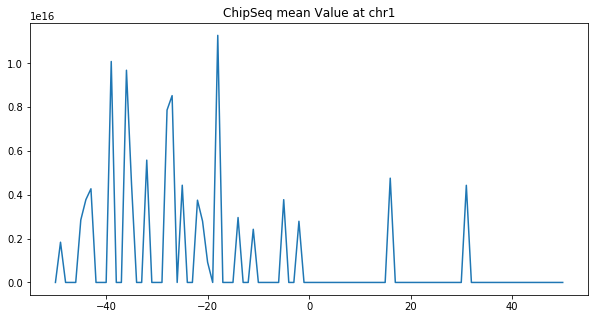

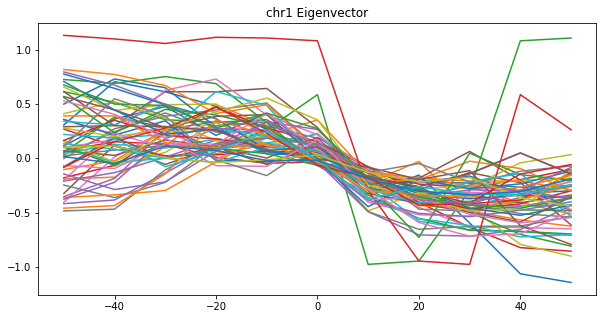

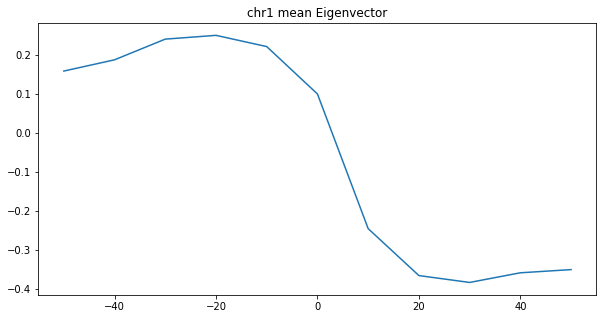

In [21]:
factor = 10
win_len = 5*factor
ch = 'chr1'
x = np.linspace(-win_len, win_len, win_len+win_len+1)
z = get_window(a.inter_pd, ch, 'signalValue', 'HMM2', win_len)

plt.figure(1, figsize =(10, 5))
plt.title('ChipSeq Value at '+ch)
for i in z:
    plt.plot(x, i)

plt.figure(2, figsize =(10,5))
plt.title('ChipSeq mean Value at '+ch)
plt.plot(x, np.mean(z, axis = 0))

z2 = get_window(a.inter_pd, ch, 'E1', 'HMM2', win_len)
plt.figure(3, figsize =(10, 5))
plt.title(ch +' Eigenvector')
for i in z2:
    plt.plot(x[::factor], i[::factor])

plt.figure(4, figsize =(10,5))
plt.title(ch +' mean Eigenvector')
plt.plot(x[::factor], np.mean(z2, axis = 0)[::factor])